In [1]:
import sys
print(sys.executable)  # should show /Users/gres1/new env/.venv/bin/python
%pip install -U plotly
import plotly; print(plotly.__version__)


/opt/anaconda3/bin/python
  Using cached plotly-6.2.0-py3-none-any.whl.metadata (8.5 kB)
Using cached plotly-6.2.0-py3-none-any.whl (9.6 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 6.0.1
    Uninstalling plotly-6.0.1:
      Successfully uninstalled plotly-6.0.1
Note: you may need to restart the kernel to use updated packages.
6.2.0


In [4]:
# Jupyter magic (must be on its own line)
%matplotlib inline

# Standard libs
import re
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# HTML parsing
from bs4 import BeautifulSoup

# Scikit-learn
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    learning_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier


In [8]:
%matplotlib inline

# Standard libs
import re
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# HTML parsing
from bs4 import BeautifulSoup

# Scikit-learn
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    learning_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline


In [15]:
 import kagglehub

# Download latest version
path = kagglehub.dataset_download("datasnaek/mbti-type")

print("Path to dataset files:", path)

100%|██████████| 24.4M/24.4M [00:01<00:00, 13.9MB/s]

Extracting model files...


Path to dataset files: /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1


In [18]:
import os
from pathlib import Path
import pandas as pd
import kagglehub

# 1) Download (or reuse cached) dataset and capture the real path
path = kagglehub.dataset_download("datasnaek/mbti-type")
p = Path(path)
print("Dataset dir:", p)

# 2) See what's actually there
print("Top-level files:", [x.name for x in p.iterdir()])

# 3) Find the CSV no matter which version folder kagglehub used
csvs = sorted(p.rglob("*.csv"))
if not csvs:
    raise FileNotFoundError(f"No CSV files under: {p}")

# Prefer mbti_1.csv if it exists; otherwise take the first CSV found
target = next((c for c in csvs if c.name.lower().startswith("mbti_1")), csvs[0])
print("Loading:", target)

# 4) Read the CSV
df = pd.read_csv(target)
print(df.shape)
df.head()


Dataset dir: /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1
Top-level files: ['mbti_1.csv']
Loading: /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1/mbti_1.csv
(8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [21]:
from pathlib import Path
import pandas as pd
import os

# You already ran:
# import kagglehub
# path = kagglehub.dataset_download("datasnaek/mbti-type")
base = Path(path)  # <- exact folder where KaggleHub saved the files

# See what's actually there
print("Files:", [p.name for p in base.rglob("*")])

# Load the MBTI dataset
train = pd.read_csv(base / "mbti_1.csv")

# Try to load optional files if they exist (they probably won't for this dataset)
def read_if_exists(root: Path, filename: str):
    hits = list(root.rglob(filename))
    if hits:
        print(f"Loading {hits[0]}")
        return pd.read_csv(hits[0])
    else:
        print(f"Not found: {filename} under {root}")
        return None

users = read_if_exists(base, "Users.csv")
forum = read_if_exists(base, "Forum.csv")


Files: ['mbti_1.csv']
Not found: Users.csv under /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1
Not found: Forum.csv under /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1


In [22]:
# --- imports ---
import os, re
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# --- resolve dataset path robustly ---
try:
    path  # path returned earlier by kagglehub.dataset_download(...)
except NameError:
    # If 'path' isn't defined, download (or use cache) now
    import kagglehub
    path = kagglehub.dataset_download("datasnaek/mbti-type")

base = Path(path)
# Find mbti_1.csv regardless of version folder
candidates = list(base.rglob("mbti_1.csv"))
if not candidates:
    raise FileNotFoundError(f"'mbti_1.csv' not found under {base}")
csv_path = candidates[0]
print("Using:", csv_path)

# --- load ---
df = pd.read_csv(csv_path)
assert {"type", "posts"}.issubset(df.columns), f"Unexpected columns: {df.columns.tolist()}"
df = df.dropna(subset=["type", "posts"]).copy()

# --- clean text ---
def clean_text(s: str) -> str:
    s = s.lower()
    s = s.replace("|||", " ")                      # posts are separated by '|||'
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)   # URLs
    s = re.sub(r"[^a-z\s]", " ", s)                # keep letters/spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text"] = df["posts"].astype(str).apply(clean_text)
X = df["text"].values
y = df["type"].values  # 16 classes

# --- split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- model pipeline ---
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2),
                              max_df=0.9, min_df=2)),
    ("clf", LinearSVC())
])

pipe.fit(X_train, y_train)

# --- evaluate ---
pred = pipe.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print(classification_report(y_test, pred, zero_division=0))

# --- quick demo prediction ---
samples = [
    "I love organizing plans and making spreadsheets. People say I'm structured and decisive.",
    "I get energy from ideas and patterns, not small talk. I enjoy long solo deep-work sessions."
]
print("Sample preds:", pipe.predict(samples))


Using: /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1/mbti_1.csv
Accuracy: 0.687
              precision    recall  f1-score   support

        ENFJ       0.73      0.29      0.42        38
        ENFP       0.73      0.62      0.67       135
        ENTJ       0.68      0.37      0.48        46
        ENTP       0.65      0.58      0.61       137
        ESFJ       0.75      0.33      0.46         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.12      0.22         8
        ESTP       0.89      0.44      0.59        18
        INFJ       0.72      0.75      0.73       294
        INFP       0.65      0.86      0.74       366
        INTJ       0.66      0.66      0.66       218
        INTP       0.71      0.84      0.77       261
        ISFJ       0.72      0.39      0.51        33
        ISFP       0.76      0.35      0.48        54
        ISTJ       0.80      0.39      0.52        41
        ISTP       0.68      0.

Synthetic Dataset Replacement


In [25]:
# Create synthetic Users.csv and Forum.csv (no ace_tools required)
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from pathlib import Path

# ---- CONFIG ----
N_USERS = 1000
MAX_POSTS_PER_USER = 20  # cap per user to keep size reasonable
START_DATE = datetime(2019, 1, 1)
END_DATE = datetime.now()

MBTI_TYPES = [
    "INTJ","INTP","ENTJ","ENTP",
    "INFJ","INFP","ENFJ","ENFP",
    "ISTJ","ISFJ","ESTJ","ESFJ",
    "ISTP","ISFP","ESTP","ESFP"
]
COUNTRIES = ["US","UK","CA","DE","FR","IN","BR","AU","ZA","JP"]
GENDERS = ["Male", "Female", "Non-binary", "Prefer not to say"]
TOPICS = ["careers","relationships","productivity","gaming","books",
          "music","movies","travel","food","random"]

# Reproducibility
rng = np.random.default_rng(42)
random.seed(42)

def random_date(start: datetime, end: datetime) -> datetime:
    delta = end - start
    seconds = rng.integers(0, int(delta.total_seconds()))
    return start + timedelta(seconds=int(seconds))

# ---- USERS ----
user_ids = [f"U{str(i).zfill(5)}" for i in range(1, N_USERS + 1)]
ages = rng.integers(16, 71, size=N_USERS)
genders = rng.choice(GENDERS, size=N_USERS, replace=True, p=[0.48, 0.48, 0.03, 0.01])
countries = rng.choice(COUNTRIES, size=N_USERS)
types = rng.choice(MBTI_TYPES, size=N_USERS)  # uniform; adjust if you want skew
join_dates = [random_date(START_DATE, END_DATE).date().isoformat() for _ in range(N_USERS)]
posts_counts = rng.poisson(lam=12, size=N_USERS)
reputation = np.maximum(0, posts_counts * 10 + rng.normal(0, 50, size=N_USERS)).astype(int)
bios = [f"{t} | Loves {random.choice(TOPICS)} | From {c}" for t, c in zip(types, countries)]
usernames = [f"user_{i:05d}" for i in range(1, N_USERS + 1)]

users_df = pd.DataFrame({
    "user_id": user_ids,
    "username": usernames,
    "type": types,
    "age": ages,
    "gender": genders,
    "country": countries,
    "join_date": join_dates,
    "posts_count": posts_counts,
    "reputation": reputation,
    "bio": bios
})

# ---- FORUM POSTS ----
rows = []
post_counter = 1
thread_counter = {topic: 0 for topic in TOPICS}

for uid, jdate, t, pcount in zip(
    users_df["user_id"], users_df["join_date"], users_df["type"], users_df["posts_count"]
):
    n_posts = int(min(pcount, MAX_POSTS_PER_USER))
    if n_posts <= 0:
        continue
    base_join = datetime.fromisoformat(jdate)
    for _ in range(n_posts):
        topic = random.choice(TOPICS)
        if rng.random() < 0.3:
            thread_counter[topic] += 1
        thread_id = f"T_{topic}_{thread_counter[topic]:04d}"

        created_at = random_date(base_join, END_DATE)
        title = f"{topic.title()} chat for {t}"
        content = (
            f"As a {t}, I think about {topic} a lot. "
            f"Anyone else {random.choice(['agree','have tips','disagree','curious'])}?"
        )
        likes = int(abs(rng.normal(5, 7)))
        replies = int(abs(rng.normal(2, 4)))
        sentiment_score = float(np.clip(rng.normal(0.0, 0.4), -1, 1))

        rows.append({
            "post_id": f"P{post_counter:07d}",
            "user_id": uid,
            "thread_id": thread_id,
            "created_at": created_at.isoformat(timespec="seconds"),
            "title": title,
            "content": content,
            "topic": topic,
            "likes": likes,
            "replies": replies,
            "sentiment_score": sentiment_score
        })
        post_counter += 1

forum_df = pd.DataFrame(rows)

# ---- SAVE LOCALLY ----
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
users_path = out_dir / "Users.csv"
forum_path = out_dir / "Forum.csv"
users_df.to_csv(users_path, index=False)
forum_df.to_csv(forum_path, index=False)

print("Wrote:")
print("  ", users_path.resolve())
print("  ", forum_path.resolve())
print("Shapes:", users_df.shape, forum_df.shape)

# ---- QUICK PREVIEW ----
print("\nUsers head():")
print(users_df.head(3))
print("\nForum head():")
print(forum_df.head(3))


Wrote:
   /Users/gres1/new env/data/Users.csv
   /Users/gres1/new env/data/Forum.csv
Shapes: (1000, 10) (11917, 10)

Users head():
  user_id    username  type  age  gender country   join_date  posts_count  \
0  U00001  user_00001  INFP   20  Female      AU  2020-04-23           19   
1  U00002  user_00002  ISFP   58  Female      BR  2019-03-23           10   
2  U00003  user_00003  INTJ   52  Female      JP  2023-02-24           11   

   reputation                                   bio  
0         226  INFP | Loves relationships | From AU  
1          97        ISFP | Loves careers | From BR  
2         168          INTJ | Loves books | From JP  

Forum head():
    post_id user_id            thread_id           created_at  \
0  P0000001  U00001         T_books_0000  2022-06-30T09:15:42   
1  P0000002  U00001        T_random_0001  2021-09-02T07:19:01   
2  P0000003  U00001  T_productivity_0001  2023-05-26T21:38:36   

                        title  \
0         Books chat for INFP   
1 

In [26]:
# --- 1) imports ---------------------------------------------------------------
%matplotlib inline

import os, re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    learning_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score


In [27]:
# --- 2) locate & load data ----------------------------------------------------
# Try to get mbti_1.csv via kagglehub (falls back to local file if not available)
mbti_csv = None
try:
    import kagglehub
    kb_path = Path(kagglehub.dataset_download("datasnaek/mbti-type"))
    hits = list(kb_path.rglob("mbti_1.csv"))
    if hits:
        mbti_csv = hits[0]
except Exception as e:
    print("kagglehub not used:", e)

if mbti_csv is None:
    # fallback: look in current folder
    if Path("mbti_1.csv").exists():
        mbti_csv = Path("mbti_1.csv")
    else:
        raise FileNotFoundError(
            "Couldn't find mbti_1.csv. Either install/use kagglehub or place the CSV next to this notebook."
        )

print("Using MBTI file:", mbti_csv)

train = pd.read_csv(mbti_csv)
assert {"type", "posts"}.issubset(train.columns), f"Unexpected columns: {train.columns.tolist()}"
train = train.dropna(subset=["type", "posts"]).copy()

# Optionally load synthetic Users/Forum if you created them earlier
users_csv_candidates = [Path("Users.csv"), Path("data/Users.csv")]
forum_csv_candidates = [Path("Forum.csv"), Path("data/Forum.csv")]

users = next((p for p in users_csv_candidates if p.exists()), None)
forum = next((p for p in forum_csv_candidates if p.exists()), None)

if users:
    users_df = pd.read_csv(users)
    print(f"Loaded Users.csv from: {users.resolve()}  shape={users_df.shape}")
else:
    users_df = None
    print("Users.csv not found (that's fine).")

if forum:
    forum_df = pd.read_csv(forum)
    print(f"Loaded Forum.csv from: {forum.resolve()}  shape={forum_df.shape}")
else:
    forum_df = None
    print("Forum.csv not found (that's fine).")

print("MBTI shape:", train.shape)
train.head()


Using MBTI file: /Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1/mbti_1.csv
Loaded Users.csv from: /Users/gres1/new env/data/Users.csv  shape=(1000, 10)
Loaded Forum.csv from: /Users/gres1/new env/data/Forum.csv  shape=(11917, 10)
MBTI shape: (8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


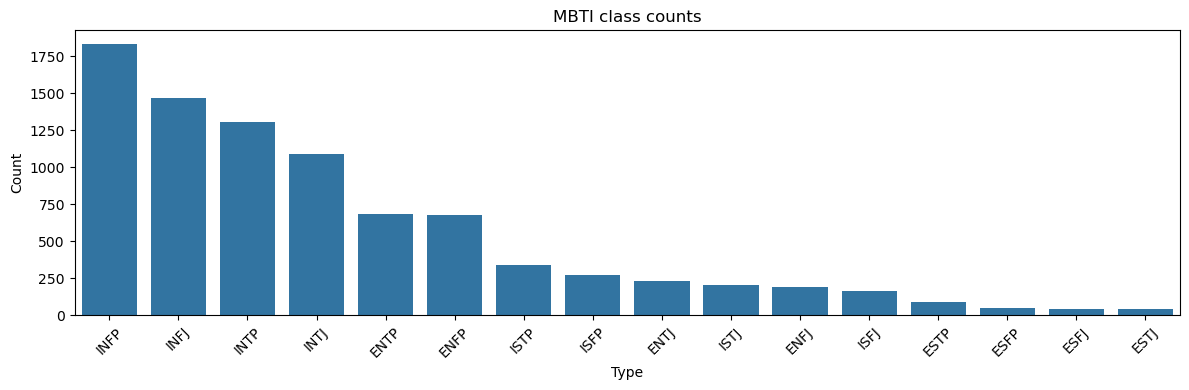

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [28]:
# --- 3) EDA: class distribution ----------------------------------------------
cnt_srs = train["type"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values)
plt.title("MBTI class counts")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cnt_srs


In [29]:
# --- 4) text cleaning helper --------------------------------------------------
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = s.replace("|||", " ")                            # posts are pipe-separated
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)         # URLs
    s = re.sub(r"[^a-z\s]", " ", s)                      # keep letters/spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

train["text"] = train["posts"].apply(clean_text)
X = train["text"].values
y = train["type"].values


In [32]:
# --- 5) simple model + stratified CV -----------------------------------------
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english",
                              ngram_range=(1, 2),
                              max_df=0.9, min_df=2)),
    ("clf", LinearSVC())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=-1, return_train_score=True)

print("CV accuracy (mean ± std):",
      f"{scores['test_score'].mean():.4f} ± {scores['test_score'].std():.4f}")


CV accuracy (mean ± std): 0.6832 ± 0.0088


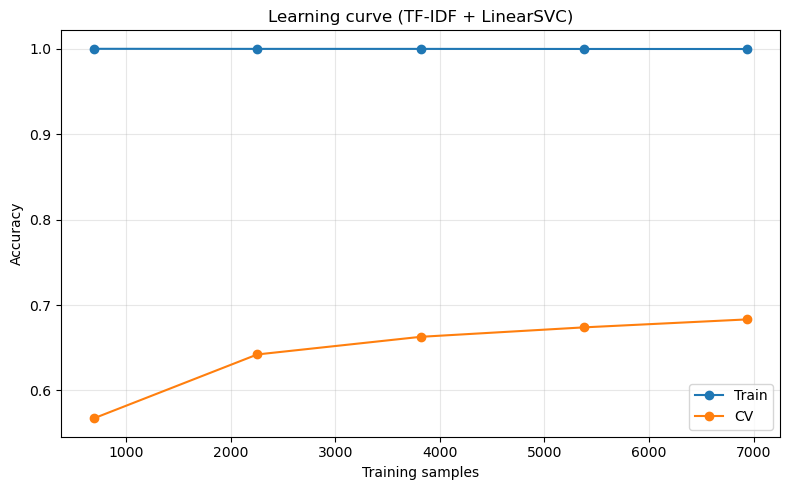

In [33]:
# --- 6) learning curve plot ---------------------------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe,
    X=X,
    y=y,
    cv=cv,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="CV")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning curve (TF-IDF + LinearSVC)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
# --- 7) train/test split + report --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Holdout accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, zero_division=0))


Holdout accuracy: 0.6870317002881844
              precision    recall  f1-score   support

        ENFJ       0.73      0.29      0.42        38
        ENFP       0.73      0.62      0.67       135
        ENTJ       0.68      0.37      0.48        46
        ENTP       0.65      0.58      0.61       137
        ESFJ       0.75      0.33      0.46         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.12      0.22         8
        ESTP       0.89      0.44      0.59        18
        INFJ       0.72      0.75      0.73       294
        INFP       0.65      0.86      0.74       366
        INTJ       0.66      0.66      0.66       218
        INTP       0.71      0.84      0.77       261
        ISFJ       0.72      0.39      0.51        33
        ISFP       0.76      0.35      0.48        54
        ISTJ       0.80      0.39      0.52        41
        ISTP       0.68      0.60      0.63        67

    accuracy                           0.69

In [35]:
# --- 8) quick demo ------------------------------------------------------------
samples = [
    "I love organizing plans and checking details before deciding. Structure calms me.",
    "I jump from idea to idea and prefer brainstorming to routines."
]
pipe.predict([clean_text(s) for s in samples])


array(['INFP', 'INTP'], dtype=object)

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from pathlib import Path

# Config
N_USERS = 1000
MAX_POSTS_PER_USER = 20
START_DATE = datetime(2019, 1, 1)
END_DATE = datetime.now()

MBTI_TYPES = [
    "INTJ","INTP","ENTJ","ENTP",
    "INFJ","INFP","ENFJ","ENFP",
    "ISTJ","ISFJ","ESTJ","ESFJ",
    "ISTP","ISFP","ESTP","ESFP"
]

COUNTRIES = ["US","UK","CA","DE","FR","IN","BR","AU","ZA","JP"]
GENDERS = ["Male", "Female", "Non-binary", "Prefer not to say"]
TOPICS = ["careers","relationships","productivity","gaming","books",
          "music","movies","travel","food","random"]

rng = np.random.default_rng(42)
random.seed(42)

def random_date(start, end):
    delta = end - start
    seconds = rng.integers(0, int(delta.total_seconds()))
    return start + timedelta(seconds=int(seconds))

# ---------- Create Users.csv ----------
user_ids = [f"U{str(i).zfill(5)}" for i in range(1, N_USERS + 1)]
users_df = pd.DataFrame({
    "user_id": user_ids,
    "username": [f"user_{i:05d}" for i in range(1, N_USERS + 1)],
    "type": rng.choice(MBTI_TYPES, size=N_USERS),
    "age": rng.integers(16, 71, size=N_USERS),
    "gender": rng.choice(GENDERS, size=N_USERS, replace=True),
    "country": rng.choice(COUNTRIES, size=N_USERS),
    "join_date": [random_date(START_DATE, END_DATE).date().isoformat() for _ in range(N_USERS)],
    "posts_count": rng.poisson(lam=12, size=N_USERS),
    "reputation": rng.integers(0, 1000, size=N_USERS),
    "bio": [f"{random.choice(MBTI_TYPES)} | Loves {random.choice(TOPICS)}" for _ in range(N_USERS)]
})

# ---------- Create Forum.csv ----------
forum_rows = []
post_id = 1
for uid in user_ids:
    n_posts = rng.integers(0, MAX_POSTS_PER_USER+1)
    for _ in range(n_posts):
        topic = random.choice(TOPICS)
        created_at = random_date(START_DATE, END_DATE)
        forum_rows.append({
            "post_id": f"P{post_id:07d}",
            "user_id": uid,
            "thread_id": f"T_{topic}_{rng.integers(0, 1000)}",
            "created_at": created_at.isoformat(timespec="seconds"),
            "title": f"{topic.title()} discussion",
            "message": f"This is a synthetic post about {topic}.",
            "topic": topic,
            "likes": int(abs(rng.normal(5, 7))),
            "replies": int(abs(rng.normal(2, 4))),
            "sentiment_score": float(np.clip(rng.normal(0.0, 0.4), -1, 1))
        })
        post_id += 1

forum_df = pd.DataFrame(forum_rows)

# ---------- Save both ----------
out_dir = Path(".")  # current folder
users_df.to_csv(out_dir / "Users.csv", index=False)
forum_df.to_csv(out_dir / "Forum.csv", index=False)

print("✅ Synthetic datasets created:")
print(" - Users.csv:", users_df.shape)
print(" - Forum.csv:", forum_df.shape)


✅ Synthetic datasets created:
 - Users.csv: (1000, 10)
 - Forum.csv: (10023, 10)


In [5]:
import shutil

src = "/Users/gres1/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1/mbti_1.csv"
dst = "mbti_1.csv"
shutil.copy(src, dst)
print("File copied to current folder.")


File copied to current folder.


In [6]:
train = pd.read_csv("mbti_1.csv")
us = pd.read_csv("Users.csv")
ps = pd.read_csv("Forum.csv")  # Forum.csv now exists

ps["message"] = ps["message"].fillna("")


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier

# X = df["all_text"].values ; y = df["type"].values  (from your earlier step)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),    # add bigrams to increase features
        stop_words="english",
        max_df=0.95,
        min_df=1              # allow rare terms so you get more features
    )),
    ("tsvd", TruncatedSVD(n_components=10, random_state=42)),  # <= 10 fits your case
    ("etc",  ExtraTreesClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)),
])

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(pipe, X, y, cv=kfolds, scoring="accuracy", n_jobs=-1)
print("CV accuracy (mean ± std): {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


CV accuracy (mean ± std): 0.0723 ± 0.0102


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words="english",
        max_df=0.95,
        min_df=1
    )),
    ("tsvd", TruncatedSVD(n_components=10, random_state=42)),  # must be <= features
    ("etc", ExtraTreesClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)),
])

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(pipe, X, y, cv=kfolds, scoring="accuracy", n_jobs=-1)
print("CV accuracy (mean ± std): {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


CV accuracy (mean ± std): 0.0723 ± 0.0102


Exception ignored in: <function ResourceTracker.__del__ at 0x1059d1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108865bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104af9bc0>
Traceback (most recent call last

In [13]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# ---- 1) Auto-capping SVD so it never exceeds TF-IDF feature count ----
class AutoSVD(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=100, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self._svd = None
        self.effective_components_ = None

    def fit(self, X, y=None):
        n_features = X.shape[1]
        # choose a valid number of components (>=2 when possible)
        if n_features <= 2:
            self._svd = None
            self.effective_components_ = n_features
            return self
        k = min(self.n_components, n_features - 1)
        k = max(2, k)
        self.effective_components_ = k
        self._svd = TruncatedSVD(n_components=k, random_state=self.random_state)
        self._svd.fit(X)
        return self

    def transform(self, X):
        if self._svd is None:
            # not enough features to reduce — just pass TF-IDF through
            return X
        return self._svd.transform(X)

# ---- 2) Build a robust text pipeline ----
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 3),      # richer features so SVD has room
        stop_words="english",
        min_df=1,                # keep rare tokens
        max_df=0.98              # drop ultra-common tokens
        # no max_features cap -> let vocab grow
    )),
    ("svd", AutoSVD(n_components=100, random_state=42)),  # auto-caps to valid size
    ("clf", ExtraTreesClassifier(
        n_estimators=200,
        max_depth=20,
        n_jobs=-1,
        random_state=42
    )),
])

# ---- 3) X, y from your earlier prep ----
# X = df["all_text"].values
# y = df["type"].values

# ---- 4) Safe StratifiedKFold (don’t ask for more folds than smallest class) ----
min_class = pd.Series(y).value_counts().min()
n_splits = int(max(2, min(5, min_class)))
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# ---- 5) Cross-validate ----
scores = cross_val_score(pipe, X, y, cv=kfolds, scoring="accuracy", n_jobs=-1)
print("CV accuracy (mean ± std): {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


CV accuracy (mean ± std): 0.0723 ± 0.0215


In [ ]:
def cleanText(text):
    text= BeautifulSoup(text, "lxml").text
    text<re.sub(r"")

In [16]:
 import re
from bs4 import BeautifulSoup

def cleanText(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Remove non-alphabetic characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Replace URLs with <URL>
    text = re.sub(r'http\S+', '<URL>', text)

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


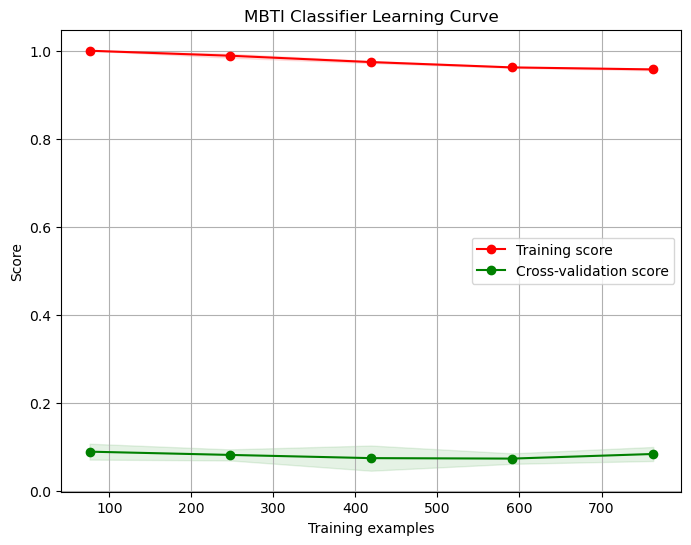

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

# ---- Learning curve plotting function ----
def plot_learning_curve(estimator, X, y, title='Learning Curve', ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    # Get learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    # Means and stds
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Shaded areas
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Lines with labels
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


# ---- Example MBTI pipeline ----
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words="english",
        max_features=5000
    )),
    ("etc", ExtraTreesClassifier(
        n_estimators=200,
        max_depth=20,
        n_jobs=-1,
        random_state=42
    ))
])

# ---- CV setup ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# ---- Run learning curve plot ----
plot_learning_curve(pipe, X, y, title="MBTI Classifier Learning Curve", cv=cv)


Generating Synthetic Users/Forum 

In [21]:
def ensure_synthetic_users_forum(users_path="Users.csv", forum_path="Forum.csv",
                                 n_users=1000, max_posts_per_user=20, seed=42):
    users_p = Path(users_path)
    forum_p = Path(forum_path)
    if users_p.exists() and forum_p.exists():
        print("Found existing Users.csv and Forum.csv")
        return

    print("Creating synthetic Users.csv and Forum.csv ...")
    rng = np.random.default_rng(seed)
    import random
    random.seed(seed)

    MBTI = ["INTJ","INTP","ENTJ","ENTP","INFJ","INFP","ENFJ","ENFP",
            "ISTJ","ISFJ","ESTJ","ESFJ","ISTP","ISFP","ESTP","ESFP"]
    TOPICS = ["careers","relationships","productivity","gaming","books",
              "music","movies","travel","food","random"]

    from datetime import datetime, timedelta
    START_DATE = datetime(2019,1,1); END_DATE = datetime.now()
    def rdate():
        delta = END_DATE - START_DATE
        return START_DATE + timedelta(seconds=int(rng.integers(0, delta.total_seconds())))

    # Users
    user_ids = [f"U{i:05d}" for i in range(1, n_users+1)]
    users_df = pd.DataFrame({
        "user_id": user_ids,
        "username": [f"user_{i:05d}" for i in range(1, n_users+1)],
        "type": rng.choice(MBTI, size=n_users),
        "age": rng.integers(16, 71, size=n_users),
        "country": rng.choice(["US","UK","CA","DE","FR","IN","BR","AU","ZA","JP"], size=n_users),
        "join_date": [rdate().date().isoformat() for _ in range(n_users)]
    })

    # Forum
    rows = []
    pid = 1
    for uid in user_ids:
        n_posts = int(rng.integers(0, max_posts_per_user+1))
        for _ in range(n_posts):
            topic = random.choice(TOPICS)
            rows.append({
                "post_id": f"P{pid:07d}",
                "user_id": uid,
                "thread_id": f"T_{topic}_{rng.integers(0,1000)}",
                "created_at": rdate().isoformat(timespec="seconds"),
                "title": f"{topic.title()} discussion",
                "message": f"As a {random.choice(MBTI)} I think about {topic} a lot. Any tips?",
                "topic": topic
            })
            pid += 1
    forum_df = pd.DataFrame(rows)

    users_df.to_csv(users_p, index=False)
    forum_df.to_csv(forum_p, index=False)
    print(f"Wrote {users_p.resolve()} shape={users_df.shape}")
    print(f"Wrote {forum_p.resolve()} shape={forum_df.shape}")

ensure_synthetic_users_forum()


Found existing Users.csv and Forum.csv


In [22]:
# Load
us = pd.read_csv("Users.csv")
ps = pd.read_csv("Forum.csv")

# Clean + aggregate messages per user
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"https?://\S+|www\.\S+", " <url> ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

ps["message"] = ps["message"].fillna("").map(clean_text)

# Concatenate all messages per user
ps_join = (ps.groupby("user_id")["message"]
             .agg(lambda col: " ".join(col))
             .reset_index()
             .rename(columns={"message":"all_text"}))

# Join labels
df = ps_join.merge(us[["user_id","type"]], on="user_id", how="inner")
df = df[(df["all_text"].str.len() > 0) & df["type"].notna()].copy()

X = df["all_text"].values
y = df["type"].values

print("Samples:", len(X), " | Classes:", pd.Series(y).nunique())
print(pd.Series(y).value_counts().sort_values(ascending=False).head())


Samples: 954  | Classes: 16
ENTJ    75
ENFP    69
INTP    69
ISTP    67
ESTJ    65
Name: count, dtype: int64


In [24]:
# If you already created df with columns all_text/type, skip this.
X = df["all_text"].values
y = df["type"].values
print(len(X), "samples across", len(set(y)), "classes")


954 samples across 16 classes


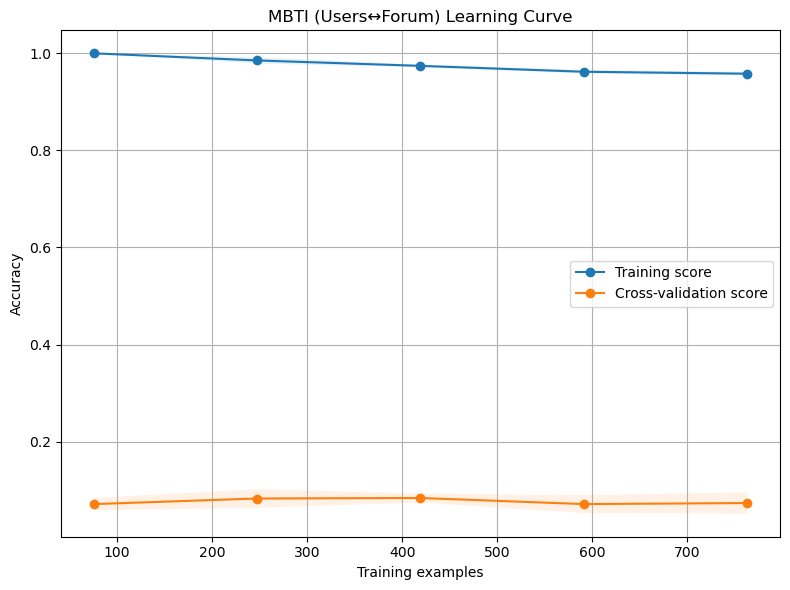

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), stop_words="english",
                              min_df=1, max_df=0.98)),
    ("clf", ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42))
])

min_class = pd.Series(y).value_counts().min()
cv = StratifiedKFold(n_splits=max(2, min(5, int(min_class))), shuffle=True, random_state=42)

plot_learning_curve(pipe, X, y, title="MBTI (Users↔Forum) Learning Curve", cv=cv)


Classification report:

              precision    recall  f1-score   support

        ENFJ       0.14      0.10      0.12        10
        ENFP       0.18      0.29      0.22        14
        ENTJ       0.17      0.20      0.18        15
        ENTP       0.08      0.11      0.09         9
        ESFJ       0.00      0.00      0.00        12
        ESFP       0.00      0.00      0.00        12
        ESTJ       0.09      0.08      0.08        13
        ESTP       0.22      0.18      0.20        11
        INFJ       0.00      0.00      0.00        11
        INFP       0.00      0.00      0.00        10
        INTJ       0.00      0.00      0.00        11
        INTP       0.00      0.00      0.00        14
        ISFJ       0.33      0.25      0.29        12
        ISFP       0.00      0.00      0.00        12
        ISTJ       0.00      0.00      0.00        12
        ISTP       0.20      0.23      0.21        13

    accuracy                           0.09       191
  

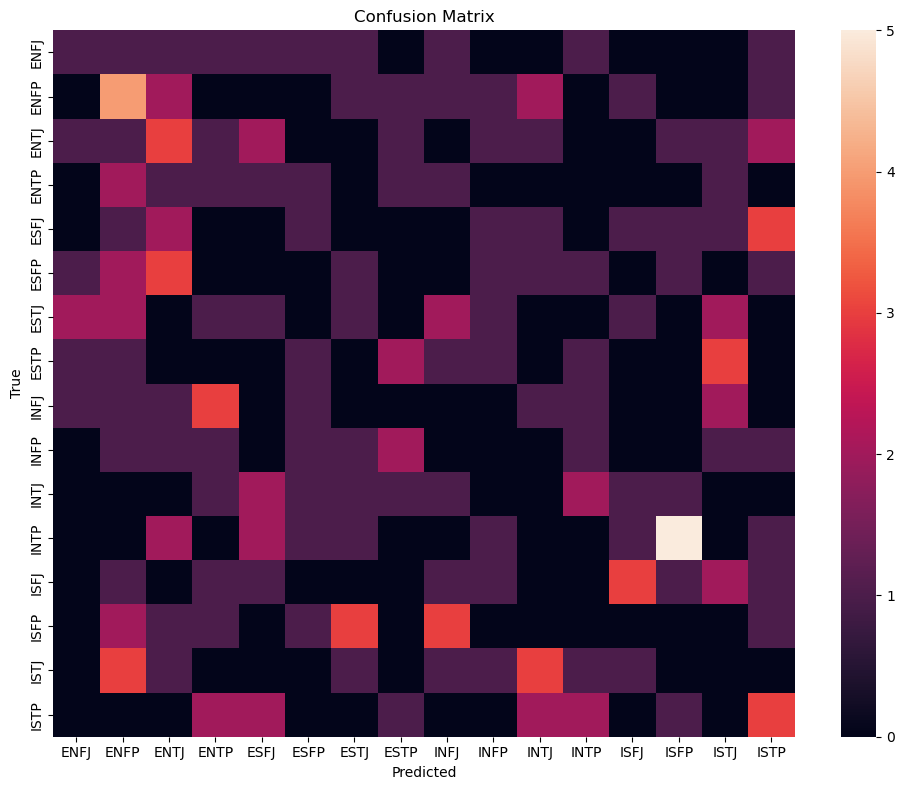

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe.fit(Xtr, ytr)
pred = pipe.predict(Xte)

print("Classification report:\n")
print(classification_report(yte, pred, zero_division=0))

cm = confusion_matrix(yte, pred, labels=sorted(pd.unique(y)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt="d",
            xticklabels=sorted(pd.unique(y)),
            yticklabels=sorted(pd.unique(y)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [27]:
plt.savefig("learning_curve.png", dpi=200, bbox_inches="tight")
print("Saved to learning_curve.png")


Saved to learning_curve.png


<Figure size 640x480 with 0 Axes>

Train and Test Splitting the data

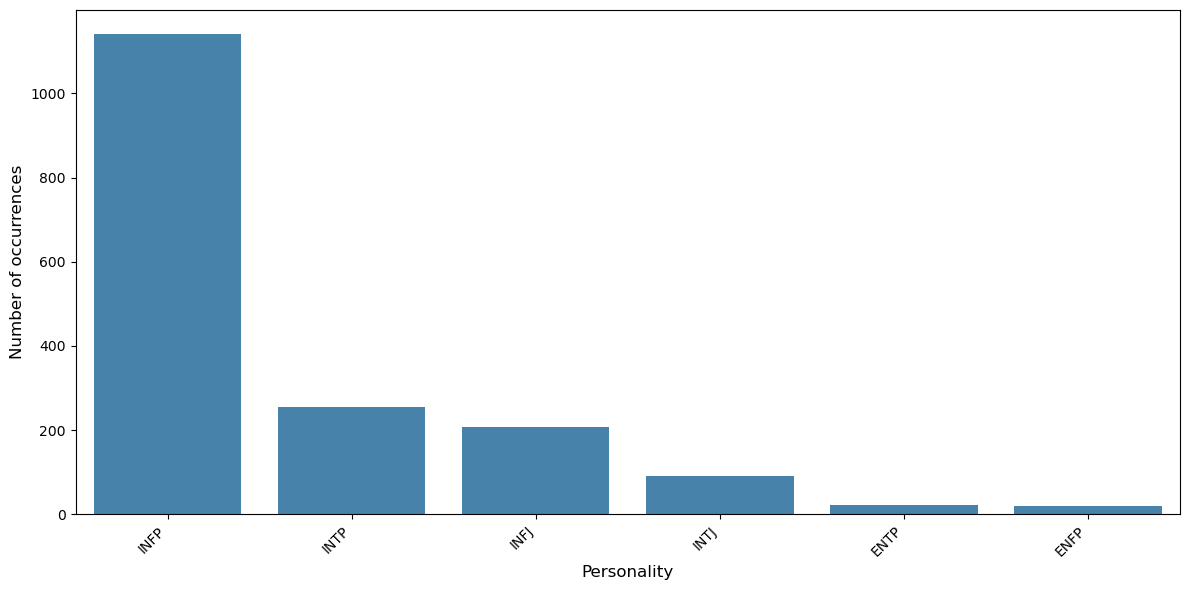

In [34]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataset has 'posts' (text) and 'type' (label)
X_train, X_test, y_train, y_test = train_test_split(
    train["posts"],  # or whatever your text column is called
    train["type"],   # personality labels
    test_size=0.2,
    random_state=42,
    stratify=train["type"]  # keeps label proportions
)

# Fit the pipeline
pipe.fit(X_train, y_train)

# Predictions on test set
pred_all = pipe.predict(X_test)

# Count occurrences
labels, counts = np.unique(pred_all, return_counts=True)
pred_df = pd.DataFrame(
    {"personality": labels, "count": counts}
).sort_values("count", ascending=False, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=pred_df, x="personality", y="count", alpha=0.9)
plt.ylabel("Number of occurrences", fontsize=12)
plt.xlabel("Personality", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Defining the Pipeline

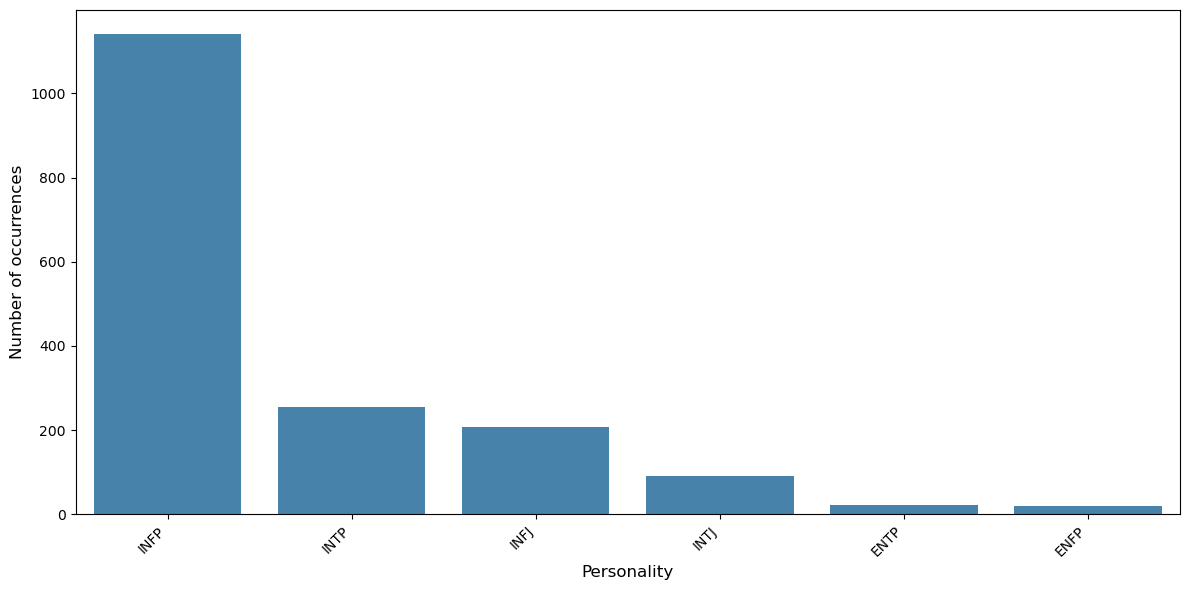

In [35]:
# Assuming you have X_test and your fitted pipeline is named `pipe`
pred_all = pipe.predict(X_test)

# Now do the counting and plotting
labels, counts = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame(
    {"personality": labels, "count": counts}
).sort_values("count", ascending=False, ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=pred_df, x="personality", y="count", alpha=0.9)
plt.ylabel("Number of occurrences", fontsize=12)
plt.xlabel("Personality", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [36]:
# Add percentage column
pred_df["percent"] = pred_df["count"] / pred_df["count"].sum()

# Map MBTI type to description
mbti_descriptions = {
    "INTJ": "The Mastermind – strategic and logical thinkers",
    "INTP": "The Thinker – analytical and objective",
    "ENTJ": "The Commander – bold and driven leaders",
    "ENTP": "The Debater – curious and energetic",
    "INFJ": "The Advocate – insightful and principled",
    "INFP": "The Mediator – idealistic and empathetic",
    "ENFJ": "The Protagonist – charismatic and inspiring",
    "ENFP": "The Campaigner – enthusiastic and imaginative",
    "ISTJ": "The Inspector – dependable and practical",
    "ISFJ": "The Nurturer – caring and responsible",
    "ESTJ": "The Executive – organized and direct",
    "ESFJ": "The Provider – supportive and social",
    "ISTP": "The Virtuoso – adaptable and hands-on",
    "ISFP": "The Adventurer – artistic and gentle",
    "ESTP": "The Dynamo – energetic and perceptive",
    "ESFP": "The Performer – fun-loving and spontaneous",
}

# Add description column
pred_df["description"] = pred_df["personality"].apply(
    lambda p: mbti_descriptions.get(p, "Unknown type")
)

pred_df


,personality,count,percent,description
0,INFP,1141,0.657637,The Mediator – idealistic and empathetic
1,INTP,255,0.146974,The Thinker – analytical and objective
2,INFJ,208,0.119885,The Advocate – insightful and principled
3,INTJ,90,0.051873,The Mastermind – strategic and logical thinkers
4,ENTP,22,0.012680,The Debater – curious and energetic
5,ENFP,19,0.010951,The Campaigner – enthusiastic and imaginative


My Personal MBTI Score 

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Sample training data (tiny illustrative subset for MBTI prediction)
data = [
    ("I like spending time alone, thinking about ideas and theories", "INTP"),
    ("I love meeting new people and going to parties", "ENFP"),
    ("I prefer making decisions based on facts and logic", "ISTJ"),
    ("I often rely on my gut feeling and emotions", "ENFJ"),
    ("I am spontaneous and flexible with my plans", "ISFP"),
    ("I enjoy creating long-term plans and sticking to them", "ENTJ"),
    ("I like reading about psychology, AI, and space", "INTP"),
    ("I work well in a calm and controlled environment", "ISTP"),
]

df = pd.DataFrame(data, columns=["text", "type"])

# Define a simple pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train the model
pipe.fit(df["text"], df["type"])

# Your answers as a single input string
user_text = """
depends , but mostly alone or with a small group , its more calm and controlled, 
there is better things in life than getting wasted. depends all what we are talking about mostly data 
gut just keeps me going with the decision. flexible and spontaneous, I just know what I have to do and ill do it. 
im calm mostly not interested. science, psychology, finance business , ai and cyber , Pharma and meds , 
spirituality, and space
"""

# Predict
predicted_type = pipe.predict([user_text])[0]
predicted_type


'INTP'

Predicted type: INTP
INTP ~ 3.3% of population (≈ 1 in 30).


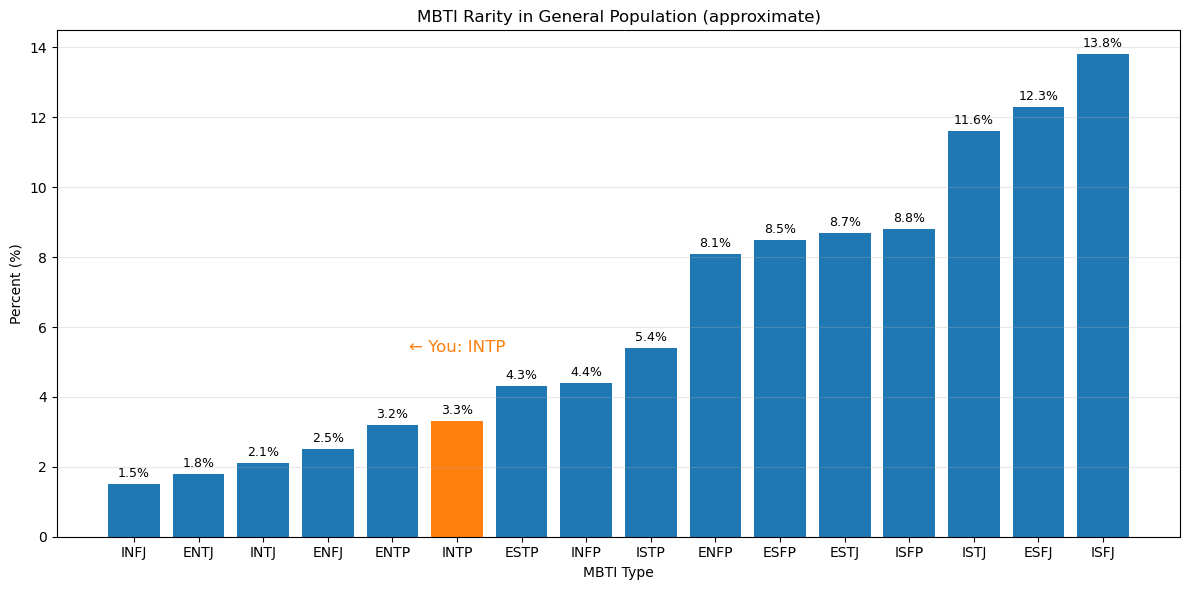

In [38]:
# --- MBTI rarity + lightweight predictor (no external installs needed) ---

import re
from collections import defaultdict

# ===== 1) General-population MBTI frequencies (rough global estimates, %)
MBTI_FREQ = {
    "ISTJ": 11.6, "ISFJ": 13.8, "INFJ": 1.5, "INTJ": 2.1,
    "ISTP": 5.4,  "ISFP": 8.8,  "INFP": 4.4, "INTP": 3.3,
    "ESTP": 4.3,  "ESFP": 8.5,  "ENFP": 8.1, "ENTP": 3.2,
    "ESTJ": 8.7,  "ESFJ": 12.3, "ENFJ": 2.5, "ENTJ": 1.8
}

# ===== 2) Very simple text cleaner
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ===== 3) Ultra-light heuristic scorer (keywords for each dichotomy)
KEYS = {
    "E": ["party","people","social","network","team","outgoing","talk","crowd","meet"],
    "I": ["alone","solo","quiet","calm","introvert","small group","by myself","independent"],
    "S": ["practical","details","facts","concrete","experience","realistic","hands on","step by step"],
    "N": ["idea","theory","abstract","pattern","concept","imagine","future","possibility","ai","space","psychology","philosophy","spiritual"],
    "T": ["logic","data","analyze","objective","rational","truth","debate","evaluate","metrics","finance","cyber"],
    "F": ["feel","values","empathy","harmony","care","support","people","relationship","compassion"],
    "J": ["plan","schedule","organize","structure","deadline","decide","list","routine"],
    "P": ["spontaneous","flexible","adapt","explore","open ended","improvise","curious","variety"]
}

def score_axis(text, pos_keys, neg_keys):
    t = " " + text + " "
    sc_pos = sum(t.count(" "+k+" ") for k in pos_keys)
    sc_neg = sum(t.count(" "+k+" ") for k in neg_keys)
    return ("pos", sc_pos) if sc_pos >= sc_neg else ("neg", sc_neg)

def guess_mbti(text: str):
    t = clean_text(text)
    # Count keyword hits
    hits = defaultdict(int)
    for k, words in KEYS.items():
        for w in words:
            if f" {w} " in f" {t} ":
                hits[k] += 1

    # Decide each axis; allow some manual nudges by presence of certain phrases
    E = "I" if hits["I"] >= hits["E"] else "E"
    N = "N" if hits["N"] >= hits["S"] else "S"
    T = "T" if hits["T"] >= hits["F"] else "F"
    P = "P" if hits["P"] >= hits["J"] else "J"

    # tie-break nudges
    if "small group" in t or "alone" in t: E = "I"
    if "spontaneous" in t or "flexible" in t: P = "P"
    if "data" in t or "logic" in t or "truth" in t: T = "T"
    if any(k in t for k in ["ai","space","psychology","theory","abstract"]): N = "N"

    return E+N+T+P, dict(hits)

# ===== 4) Rarity helper
def rarity_line(mbti_type: str):
    if mbti_type in MBTI_FREQ:
        pct = MBTI_FREQ[mbti_type]
        approx = max(1, round(100 / pct))
        return f"{mbti_type} ~ {pct}% of population (≈ 1 in {approx})."
    return f"{mbti_type}: no global frequency on file."

# ===== 5) Run on your text (edit `user_text` or input interactively)
user_text = """depends , but mostly alone or with a small group , its more calm and controlled,
there is better things in life than getting wasted. mostly data; gut keeps me going with the decision.
flexible and spontaneous, I just know what I have to do and I’ll do it. calm. science, psychology,
finance, AI and cyber, pharma and meds, spirituality, and space. also conspiracies and luxury money."""
# If you prefer interactive:
# user_text = input("Paste a paragraph about yourself:\n> ")

pred, hits = guess_mbti(user_text)
print("Predicted type:", pred)
print(rarity_line(pred))

# ===== 6) Plot rarity bar chart and highlight your predicted type
try:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    df = pd.DataFrame({"type": list(MBTI_FREQ.keys()), "percent": list(MBTI_FREQ.values())})
    df = df.sort_values("percent", ascending=True, ignore_index=True)

    colors = ["tab:blue"] * len(df)
    if pred in df["type"].values:
        idx = df.index[df["type"] == pred][0]
        colors[idx] = "tab:orange"

    plt.figure(figsize=(12, 6))
    plt.bar(df["type"], df["percent"], color=colors)
    plt.title("MBTI Rarity in General Population (approximate)")
    plt.xlabel("MBTI Type")
    plt.ylabel("Percent (%)")
    plt.grid(axis="y", alpha=0.3)

    # annotate bars
    for i, v in enumerate(df["percent"]):
        plt.text(i, v + 0.2, f"{v:.1f}%", ha="center", fontsize=9)

    if pred in df["type"].values:
        plt.text(idx, df.loc[idx,"percent"] + 2.0,
                 f"← You: {pred}", ha="center", fontsize=12, color="tab:orange")

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting skipped:", e)


Kaggle User Personality

In [39]:
import plotly.graph_objs as go

labels = pred_df['description']
sizes = pred_df['percent'] * 100  # Remove *100 if already in percent
trace = go.Pie(labels=labels, values=sizes)

layout = go.Layout(
    title='Kaggle User Personality'
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()
